# 作成したモデルのdeployとserving

01_image_classificationで作ったモデルを、Vertex AIを使ってAPIとして利用できるようにしていきます。

Vertex AIでは、作成済みのモデルをuploadし、作成したendpointにそのモデルをdeployすることで、推論APIとして呼び出すことができるようになります。  
その手順を確認していきましょう。

In [ ]:
%%bash

USER=<<username>> # 自分の名前
BUCKET=mixi-ml-handson-2022
VERSION=001
REGION=asia-northeast1

gcloud ai models upload \
  --region=${REGION} \
  --display-name=mfashion-${USER} \
  --container-image-uri=asia-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-8:latest \
  --artifact-uri=gs://${BUCKET}/${USER}/${VERSION}

gcloud ai models list \
  --region=${REGION} \
  --filter=mfashion-${USER}
    
gcloud ai endpoints create \
  --region=${REGION} \
  --display-name=mfashion-${USER}

実行が終わったら、出力されたMODEL_IDと、endpointを作成した際に出力された`ENDPOINT_ID` `・・・/asia-northeast1/endpoints/<ENDPOINT_ID>`を使って、endpointにmodelをdeployします。

In [ ]:
%%bash

USER=<<username>> # 自分の名前
REGION=asia-northeast1
MODEL_ID=<<MODEL_ID>> # 前のセルで出力されたMODEL_ID
ENDPOINT_ID=<<ENDPOINT_ID>> # 前のセルで出力されたENDPOINT_ID

gcloud ai endpoints deploy-model ${ENDPOINT_ID} \
  --region=${REGION} \
  --model=${MODEL_ID} \
  --display-name=mfashion-${USER}


上記コードの実行には数分の時間がかかります。

versionの作成が完了したら、このendpointにリクエストを投げてみましょう。

In [3]:
from google.cloud import aiplatform

def predict_json(project, endpoint, instances):    
    region = "asia-northeast1"
    aiplatform.init(project=project, location=region)
    endpoint = aiplatform.Endpoint(endpoint)
    response = endpoint.predict(instances=instances)
    return response.predictions

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def show(n_cols, n_rows, train_orig):
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(16,4))
    for ax, pixels in zip(axs.flat, train_orig):
        ax.imshow(pixels, cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

Label: 'Ankle boot'  Pred: [4.78645477e-19, 3.55020421e-24, 7.70846221e-18, 1.14386904e-19, 3.3765453e-17, 9.56018598e-10, 1.80037068e-17, 1.7216123e-10, 1.19647622e-18, 1.0]
Label: 'Pullover'  Pred: [1.03986608e-09, 4.63111128e-18, 0.999999642, 1.62839653e-12, 3.14289821e-07, 6.25233352e-21, 5.45657137e-08, 3.65233293e-26, 4.86514126e-15, 5.36797566e-21]
Label: 'Trouser'  Pred: [1.17822892e-16, 1.0, 2.04789796e-19, 1.41438918e-17, 4.46791914e-20, 6.9127e-24, 8.98174e-16, 2.29923451e-31, 8.05248901e-19, 6.19866045e-30]
Label: 'Trouser'  Pred: [4.94666802e-20, 1.0, 6.00059657e-22, 9.55082381e-20, 8.37960555e-23, 1.86363651e-27, 2.22079615e-17, 1.26060882e-36, 2.52838831e-22, 4.42966955e-34]
Label: 'Shirt'  Pred: [9.03038963e-05, 2.03516782e-13, 7.32822e-06, 1.85940735e-07, 4.8813421e-05, 1.86665157e-14, 0.999853373, 4.01768406e-18, 1.00058468e-10, 3.15955554e-14]
Label: 'Trouser'  Pred: [9.05615758e-16, 1.0, 2.15443182e-18, 6.37320957e-17, 1.39967118e-18, 5.08646657e-22, 5.6760906e-16, 

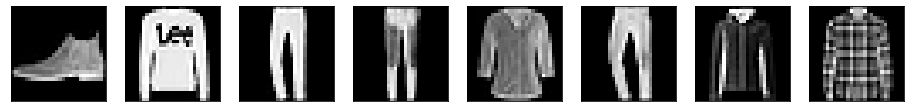

In [5]:
from tensorflow.keras.datasets import fashion_mnist
import numpy as np

project_name = 'hr-mixi'
endpoint_id = <<endpoint_id>> # 最初のセルで出力されたENDPOINT_ID
labels = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot',
]

(X_train_orig, y_train_orig), (X_test_orig, y_test_orig) = fashion_mnist.load_data()
requests = X_test_orig[0:8]

requests = np.expand_dims(requests, -1)
requests = requests / 255.0
requests = requests.tolist()

predictions = predict_json(project_name, endpoint_id, requests)
for i, p in enumerate(predictions):
    print("Label: '{}' ".format(labels[np.argmax(p)]), "Pred: {}".format(p))
show(8, 1, X_test_orig[0:8])